<a href="https://colab.research.google.com/github/shreyasat27/pennylane-27524/blob/main/Alleviating_barren_plateaus_with_local_cost_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 35.0 MB/s eta 0:00:00


In [3]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter

np.random.seed(42)

Visualizing the problem!

In [4]:
wires= 6
dev = qml.device("lightning.qubit", wires=wires, shots = 10000)


In [8]:
def global_cost_simple(rotations):
  for i in range(wires):
    qml.RX(rotations[0][i], wires=i)
    qml.RY(rotations[1][i], wires=i)
  return qml.probs(wires= range(wires))

def llocal_cost_simple(rotations):
  for i in range(wires):
    qml.RX(rotations[0][i], wires=i)
    qml.RY(rotations[1][i],wires=i)
  return [qml.probs(wires=i) for i in range(wires)]

global_circuit = qml.QNode(global_cost_simple, dev, interface ="autograd")
local_circuit = qml.QNode(llocal_cost_simple, dev, interface ="autograd")

def cost_local(rotations):
  return 1-np.sum([i for (i, _) in local_circuit(rotations)])/wires

def cost_global(rotations):
  return 1- global_circuit(rotations)[0]

To analyze each of the circuits, we provide some random initial parameters for each rotation.



In [9]:
RX = np.random.uniform(low=-np.pi, high=np.pi)
RY = np.random.uniform(low=-np.pi, high=np.pi)
rotations = [[RX for i in range(wires)], [RY for i in range(wires)]]

Examine the results

Global Cost:  0.5180000
Local Cost:  0.1125833


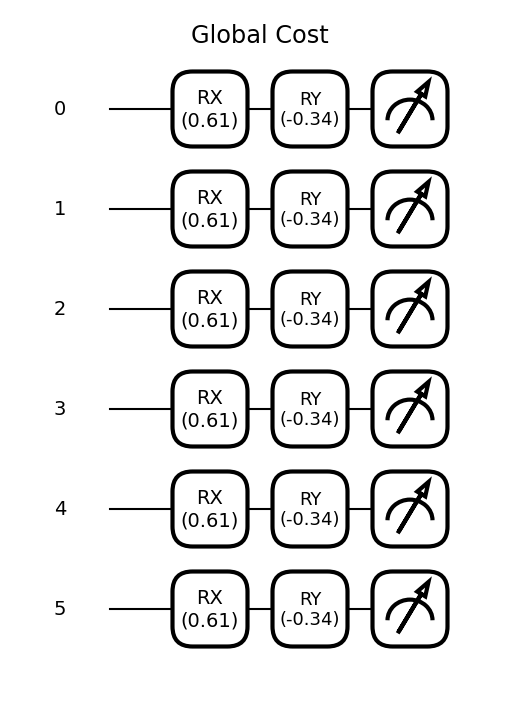

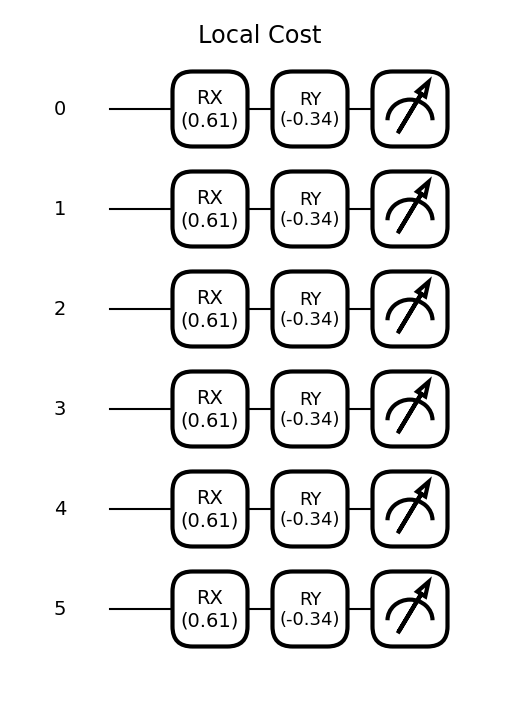

In [10]:
print("Global Cost: {: .7f}".format(cost_global(rotations)))
print("Local Cost: {: .7f}".format(cost_local(rotations)))

qml.drawer.use_style('black_white')
fig1, ax1 = qml.draw_mpl(global_circuit, decimals=2)(rotations)
fig1.suptitle("Global Cost", fontsize='xx-large')
plt.show()

fig2, ax2 = qml.draw_mpl(local_circuit, decimals=2)(rotations)
fig2.suptitle("Local Cost", fontsize='xx-large')
plt.show()

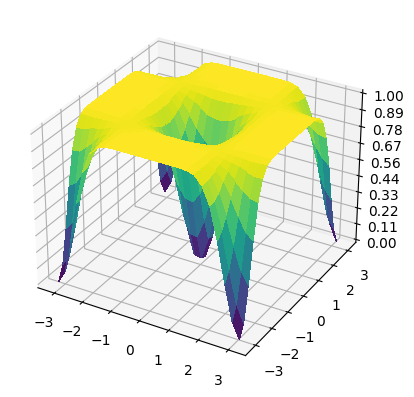

In [11]:
def generate_surface(cost_function):
    Z = []
    Z_assembler = []

    X = np.arange(-np.pi, np.pi, 0.25)
    Y = np.arange(-np.pi, np.pi, 0.25)
    X, Y = np.meshgrid(X, Y)

    for x in X[0, :]:
        for y in Y[:, 0]:
            rotations = [[x for i in range(wires)], [y for i in range(wires)]]
            Z_assembler.append(cost_function(rotations))
        Z.append(Z_assembler)
        Z_assembler = []

    Z = np.asarray(Z)
    return Z

def plot_surface(surface):
    X = np.arange(-np.pi, np.pi, 0.25)
    Y = np.arange(-np.pi, np.pi, 0.25)
    X, Y = np.meshgrid(X, Y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X, Y, surface, cmap="viridis", linewidth=0, antialiased=False)
    ax.set_zlim(0, 1)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
    plt.show()


global_surface = generate_surface(cost_global)
plot_surface(global_surface)

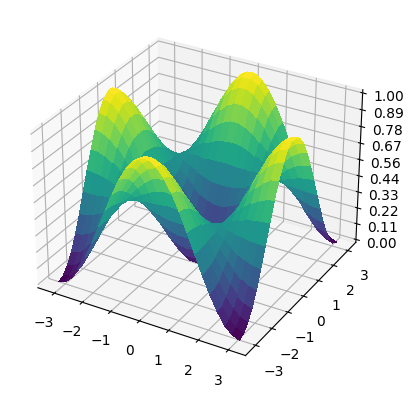

In [12]:
local_surface = generate_surface(cost_local)
plot_surface(local_surface)

While we’re at it, let us make our ansatz a little more like one we would encounter while trying to solve a VQE problem, and add entanglement.

In [13]:
def global_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    qml.broadcast(qml.CNOT, wires=range(wires), pattern="chain")
    return qml.probs(wires=range(wires))

def local_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    qml.broadcast(qml.CNOT, wires=range(wires), pattern="chain")
    return qml.probs(wires=[0])

global_circuit = qml.QNode(global_cost_simple, dev, interface="autograd")

local_circuit = qml.QNode(local_cost_simple, dev, interface="autograd")

def cost_local(rotations):
    return 1 - local_circuit(rotations)[0]

def cost_global(rotations):
    return 1 - global_circuit(rotations)[0]

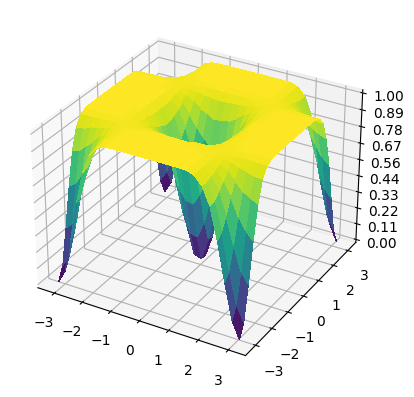

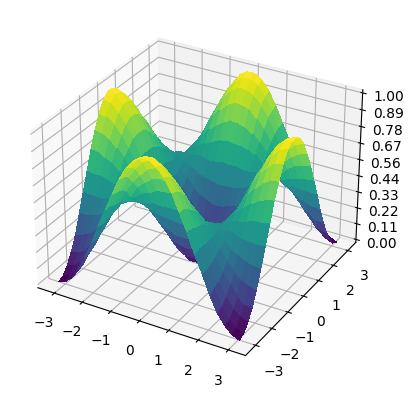

In [14]:
global_surface = generate_surface(cost_global)
plot_surface(global_surface)

local_surface = generate_surface(cost_local)
plot_surface(local_surface)


Cost after step     5:  1.0000000
Cost after step    10:  1.0000000
Cost after step    15:  1.0000000
Cost after step    20:  1.0000000
Cost after step    25:  1.0000000
Cost after step    30:  1.0000000
Cost after step    35:  1.0000000
Cost after step    40:  1.0000000
Cost after step    45:  1.0000000
Cost after step    50:  1.0000000
Cost after step    55:  1.0000000
Cost after step    60:  1.0000000
Cost after step    65:  1.0000000
Cost after step    70:  1.0000000
Cost after step    75:  1.0000000
Cost after step    80:  1.0000000
Cost after step    85:  1.0000000
Cost after step    90:  1.0000000
Cost after step    95:  1.0000000
Cost after step   100:  1.0000000


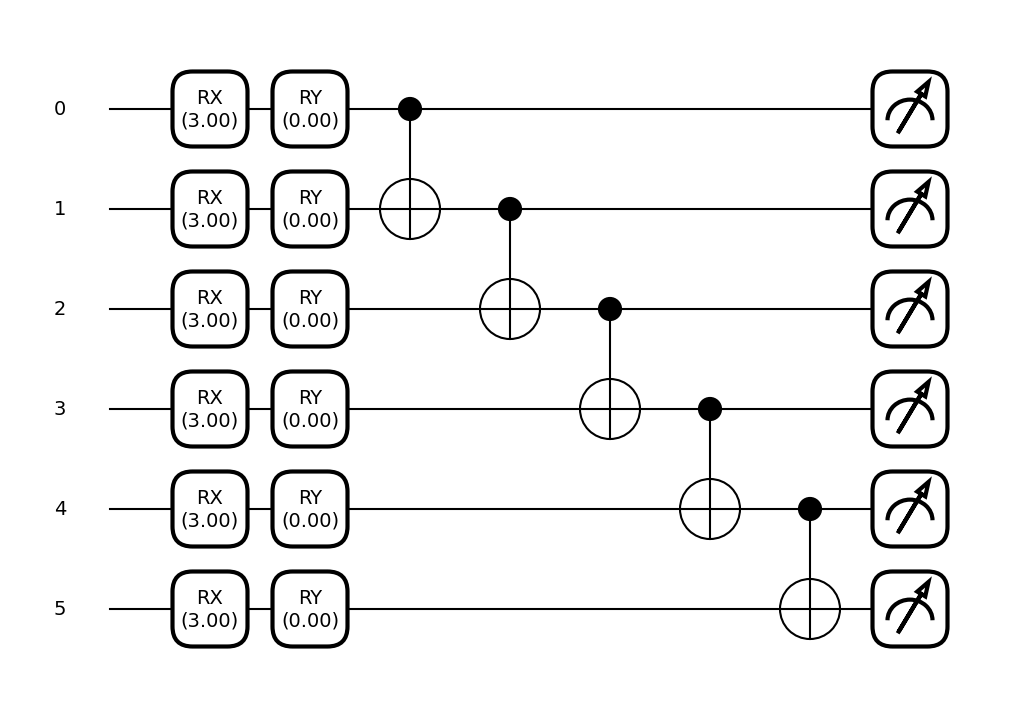

In [15]:
rotations = np.array([[3.] * len(range(wires)), [0.] * len(range(wires))], requires_grad=True)
opt = qml.GradientDescentOptimizer(stepsize=0.2)
steps = 100
params_global = rotations
for i in range(steps):
    # update the circuit parameters
    params_global = opt.step(cost_global, params_global)

    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost_global(params_global)))
    if cost_global(params_global) < 0.1:
        break
fig, ax = qml.draw_mpl(global_circuit, decimals=2)(params_global)
plt.show()

Cost after step     5:  0.9875000
Cost after step    10:  0.9709000
Cost after step    15:  0.9224000
Cost after step    20:  0.8175000
Cost after step    25:  0.6216000
Cost after step    30:  0.3770000
Cost after step    35:  0.1767000
Cost after step    40:  0.0718000


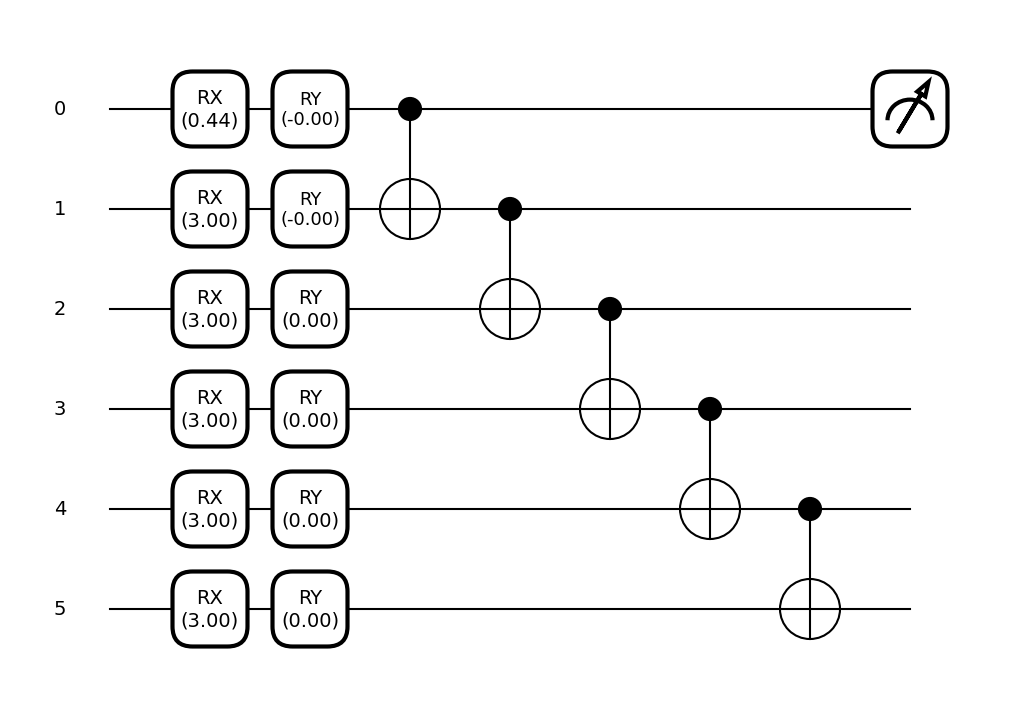

In [16]:
rotations = np.array([[3. for i in range(wires)], [0. for i in range(wires)]], requires_grad=True)
opt = qml.GradientDescentOptimizer(stepsize=0.2)
steps = 100
params_local = rotations
for i in range(steps):
    # update the circuit parameters
    params_local = opt.step(cost_local, params_local)

    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost_local(params_local)))
    if cost_local(params_local) < 0.05:
        break

fig, ax = qml.draw_mpl(local_circuit, decimals=2)(params_local)
plt.show()

In [17]:
cost_global(params_local)

1.0

In [18]:
_dev = qml.device("lightning.qubit", wires=wires, shots=None)
global_circuit = qml.QNode(global_cost_simple, _dev, interface="autograd")
print(
    "Current cost: "
    + str(cost_global(params_local))
    + ".\nInitial cost: "
    + str(cost_global([[3.0 for i in range(wires)], [0 for i in range(wires)]]))
    + ".\nDifference: "
    + str(
        cost_global([[3.0 for i in range(wires)], [0 for i in range(wires)]])
        - cost_global(params_local)
    )
)



Current cost: 0.999999999996999.
Initial cost: 0.9999999999999843.
Difference: 2.985389713217046e-12


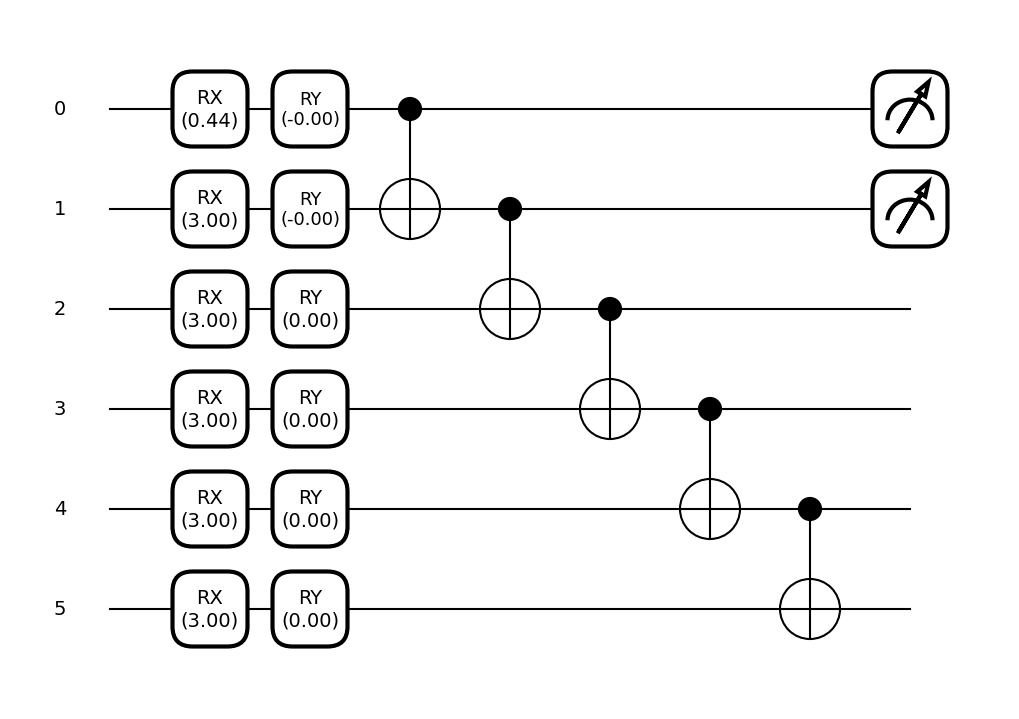

0.9951
Cost after step    10:  0.9900000. Locality: 2
Cost after step    20:  0.9700000. Locality: 2
Cost after step    30:  0.9298000. Locality: 2
Cost after step    40:  0.8345000. Locality: 2
Cost after step    50:  0.6622000. Locality: 2
Cost after step    60:  0.4215000. Locality: 2
Cost after step    70:  0.2105000. Locality: 2
Cost after step    80:  0.0881000. Locality: 2
---Switching Locality---
Cost after step    90:  0.9890000. Locality: 3
Cost after step   100:  0.9699000. Locality: 3
Cost after step   110:  0.9339000. Locality: 3
Cost after step   120:  0.8542000. Locality: 3
Cost after step   130:  0.6973000. Locality: 3
Cost after step   140:  0.4742000. Locality: 3
Cost after step   150:  0.2514000. Locality: 3
Cost after step   160:  0.1109000. Locality: 3
---Switching Locality---
Cost after step   170:  0.9901000. Locality: 4
Cost after step   180:  0.9767000. Locality: 4
Cost after step   190:  0.9458000. Locality: 4
Cost after step   200:  0.8722000. Locality: 4
Cos

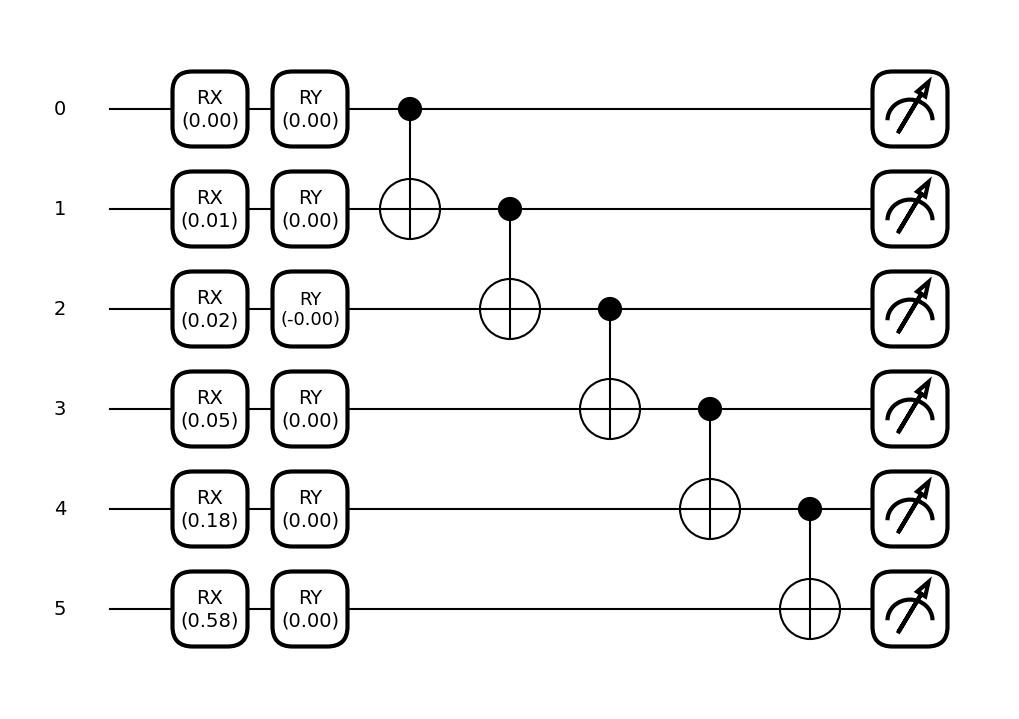

In [19]:
def tunable_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    qml.broadcast(qml.CNOT, wires=range(wires), pattern="chain")
    return qml.probs(range(locality))

def cost_tunable(rotations):
    return 1 - tunable_circuit(rotations)[0]

tunable_circuit = qml.QNode(tunable_cost_simple, dev, interface="autograd")
locality = 2
params_tunable = params_local
fig, ax = qml.draw_mpl(tunable_circuit, decimals=2)(params_tunable)
plt.show()
print(cost_tunable(params_tunable))

locality = 2
opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 600
for i in range(steps):
    # update the circuit parameters
    params_tunable = opt.step(cost_tunable, params_tunable)

    runCost = cost_tunable(params_tunable)
    if (i + 1) % 10 == 0:
        print(
            "Cost after step {:5d}: {: .7f}".format(i + 1, runCost)
            + ". Locality: "
            + str(locality)
        )

    if runCost < 0.1 and locality < wires:
        print("---Switching Locality---")
        locality += 1
        continue
    elif runCost < 0.1 and locality >= wires:
        break
fig, ax = qml.draw_mpl(tunable_circuit, decimals=2)(params_tunable)
plt.show()

A more thorough analysis

In [ ]:
samples = 10
plateau = 0
trained = 0
opt = qml.GradientDescentOptimizer(stepsize=0.2)
steps = 400
wires = 8

dev = qml.device("lightning.qubit", wires=wires, shots=10000)
global_circuit = qml.QNode(global_cost_simple, dev, interface="autograd")

for runs in range(samples):
    print("--- New run! ---")
    has_been_trained = False

    params_global = np.random.uniform(-np.pi, np.pi, (2, wires), requires_grad=True)

    for i in range(steps):
        # update the circuit parameters
        params_global = opt.step(cost_global, params_global)

        if (i + 1) % 20 == 0:
            print("Cost after step {:5d}: {: .7f}".format(i + 1, cost_global(params_global)))
        if cost_global(params_global) < 0.9:
            has_been_trained = True
            break
    if has_been_trained:
        trained = trained + 1
    else:
        plateau = plateau + 1
    print("Trained: {:5d}".format(trained))
    print("Plateau'd: {:5d}".format(plateau))


samples = 10
plateau = 0
trained = 0
opt = qml.GradientDescentOptimizer(stepsize=0.2)
steps = 200
wires = 8

dev = qml.device("lightning.qubit", wires=wires, shots=10000)
tunable_circuit = qml.QNode(tunable_cost_simple, dev, interface="autograd")

for runs in range(samples):
    locality = 1
    print("--- New run! ---")
    has_been_trained = False

    params_tunable = np.random.uniform(-np.pi, np.pi, (2, wires), requires_grad=True)
    for i in range(steps):
        # update the circuit parameters
        params_tunable = opt.step(cost_tunable, params_tunable)

        runCost = cost_tunable(params_tunable)
        if (i + 1) % 10 == 0:
            print(
                "Cost after step {:5d}: {: .7f}".format(i + 1, runCost)
                + ". Locality: "
                + str(locality)
            )

        if runCost < 0.5 and locality < wires:
            print("---Switching Locality---")
            locality += 1
            continue
        elif runCost < 0.1 and locality >= wires:
            trained = trained + 1
            has_been_trained = True
            break
    if not has_been_trained:
        plateau = plateau + 1
    print("Trained: {:5d}".format(trained))
    print("Plateau'd: {:5d}".format(plateau))

--- New run! ---
Cost after step    20:  0.9998000
Cost after step    40:  0.9998000
Cost after step    60:  0.9995000
Cost after step    80:  1.0000000
Cost after step   100:  0.9998000
Cost after step   120:  0.9996000
Cost after step   140:  0.9994000
Cost after step   160:  0.9998000
Cost after step   180:  0.9994000
Cost after step   200:  0.9996000
Cost after step   220:  0.9995000
Cost after step   240:  0.9992000
Cost after step   260:  0.9996000
Cost after step   280:  0.9992000
Cost after step   300:  0.9997000
Cost after step   320:  0.9993000
Cost after step   340:  0.9985000
Cost after step   360:  0.9987000
Cost after step   380:  0.9987000
Cost after step   400:  0.9994000
Trained:     0
Plateau'd:     1
--- New run! ---


In the global case, anywhere between 70-80% of starting positions are untrainable, a significant number. It is likely that, as the complexity of our ansatz—and the number of qubits—increases, this factor will increase.

We can compare that to our local cost function, where every single area trained, and most even trained in less time. While these examples are simple, this local-vs-global cost behaviour has been shown to extend to more complex problems.

